# Pairs Trading Strategy using OLS Regression
This notebook implements a pairs trading strategy using co-integration testing, OLS regression, and z-score-based trading signals. Stocks are selected from the US market.

## 1. Import Required Libraries

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

## 2. Load Stock Data for Selected Tickers

In [14]:
companies = pd.DataFrame()
stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "JPM", "WMT", "JNJ", "V", "PG",
          "KO", "NFLX", "DIS", "NVDA", "VZ", "T", "IBM", "HD", "BA", "MA"]

for stock in stocks:
    ticker = yf.Ticker(stock)
    data = ticker.history(start='2017-06-01', end='2023-07-31')
    companies[stock] = data['Close']

companies.head()

,AAPL,MSFT,GOOGL,AMZN,TSLA,JPM,WMT,JNJ,V,PG,KO,NFLX,DIS,NVDA,VZ,T,IBM,HD,BA,MA
Date,,,,,,,,,,,,,,,,,,,,
2017-06-01 00:00:00-04:00,35.680153,64.035118,49.119911,49.797501,22.691334,66.622406,23.239697,103.118614,90.287666,71.196571,35.344936,162.990005,101.924919,3.563798,30.495087,16.202530,102.094543,127.895760,176.507339,117.928360
2017-06-02 00:00:00-04:00,36.208893,65.551506,49.509079,50.336498,22.656668,66.285530,23.184370,104.159592,90.997452,71.568176,35.422134,165.179993,100.954750,3.546024,30.449188,16.202530,101.679947,128.060654,179.249390,119.648544
2017-06-05 00:00:00-04:00,35.854847,66.026520,49.894768,50.567001,23.154667,66.405838,23.370726,104.383797,91.376045,71.689362,35.499321,165.059998,100.333069,3.653905,30.403294,16.177523,101.920670,127.599037,178.043259,120.317505
2017-06-06 00:00:00-04:00,35.975975,66.245743,49.536911,50.150002,23.523333,66.542213,22.983454,104.760162,90.656776,71.737846,35.491596,165.169998,99.372322,3.637365,30.449188,16.144182,101.893921,127.112701,175.970276,119.686752
2017-06-07 00:00:00-04:00,36.190262,66.126999,49.776474,50.503502,23.976667,67.304176,23.047518,104.696075,90.940674,71.713623,35.128819,165.610001,99.767929,3.681308,30.488533,16.156685,100.964394,127.739227,177.242325,119.638992


## 3. Train-Test Split and Correlation Heatmap

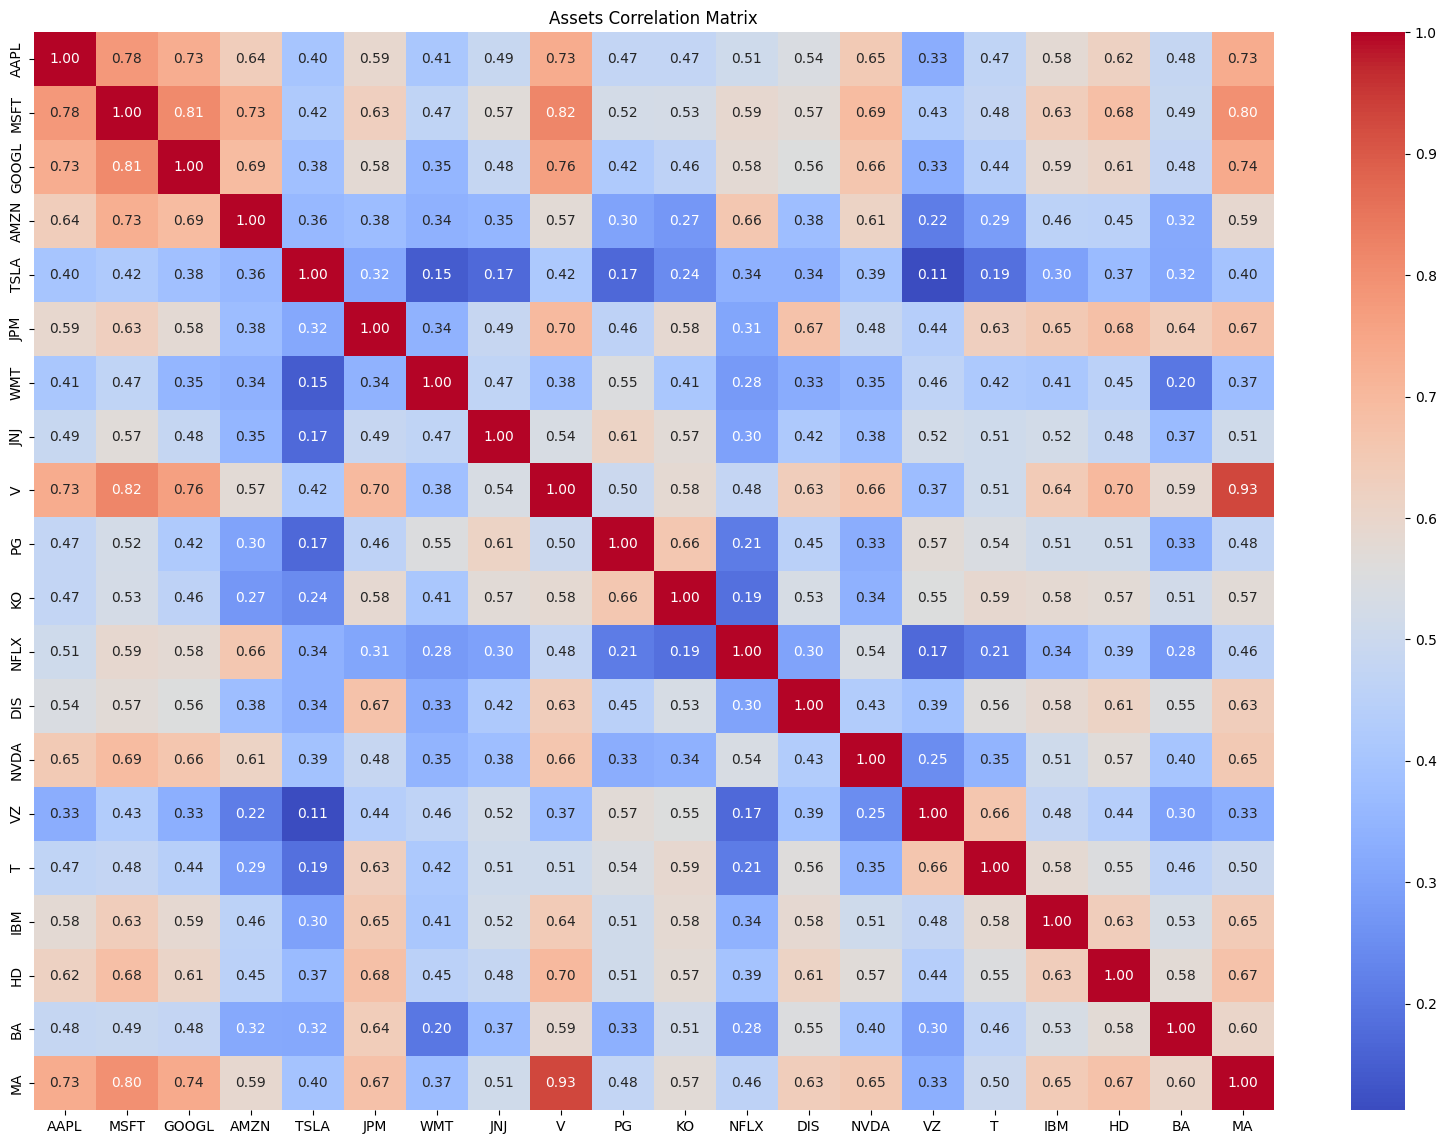

In [15]:
train_close, test_close = train_test_split(companies, test_size=0.5, shuffle=False)

plt.figure(figsize=(20,14))
sns.heatmap(train_close.pct_change().corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Assets Correlation Matrix')
plt.show()

## 4. Identify Cointegrated Pairs

In [16]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            score, pvalue, _ = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

pvalues, pairs = find_cointegrated_pairs(train_close)
print("Cointegrated Pairs:", pairs)

Cointegrated Pairs: [('GOOGL', 'HD'), ('JNJ', 'V'), ('JNJ', 'PG'), ('JNJ', 'VZ'), ('JNJ', 'MA'), ('V', 'MA'), ('KO', 'DIS'), ('IBM', 'HD'), ('IBM', 'BA'), ('IBM', 'MA'), ('HD', 'MA')]


## 5. Choose a Cointegrated Pair

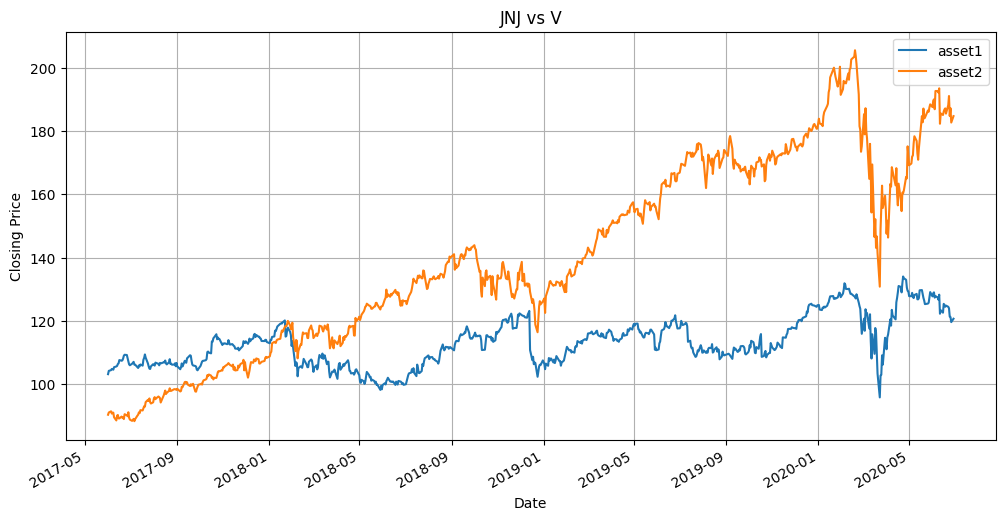

In [17]:
asset1, asset2 = 'JNJ', 'V'
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]
train[['asset1', 'asset2']].plot(figsize=(12, 6), title=f'{asset1} vs {asset2}')
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

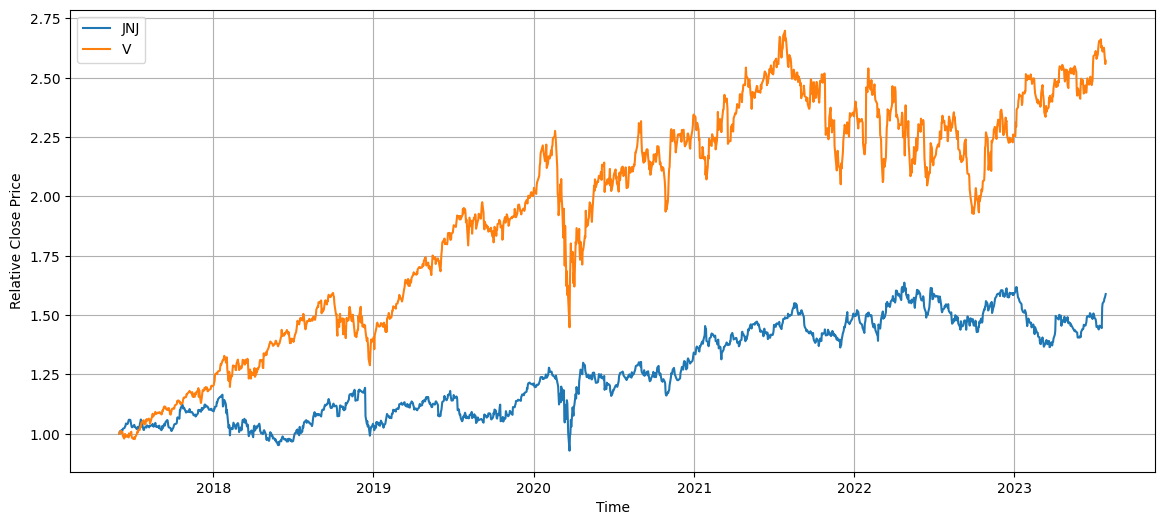

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(companies[asset1] / companies[asset1].iloc[0], label=asset1)
plt.plot(companies[asset2] / companies[asset2].iloc[0], label=asset2)
plt.xlabel("Time")
plt.ylabel("Relative Close Price")
plt.legend()
plt.grid(True)
plt.show()

## 6. Run OLS Regression and Calculate Spread

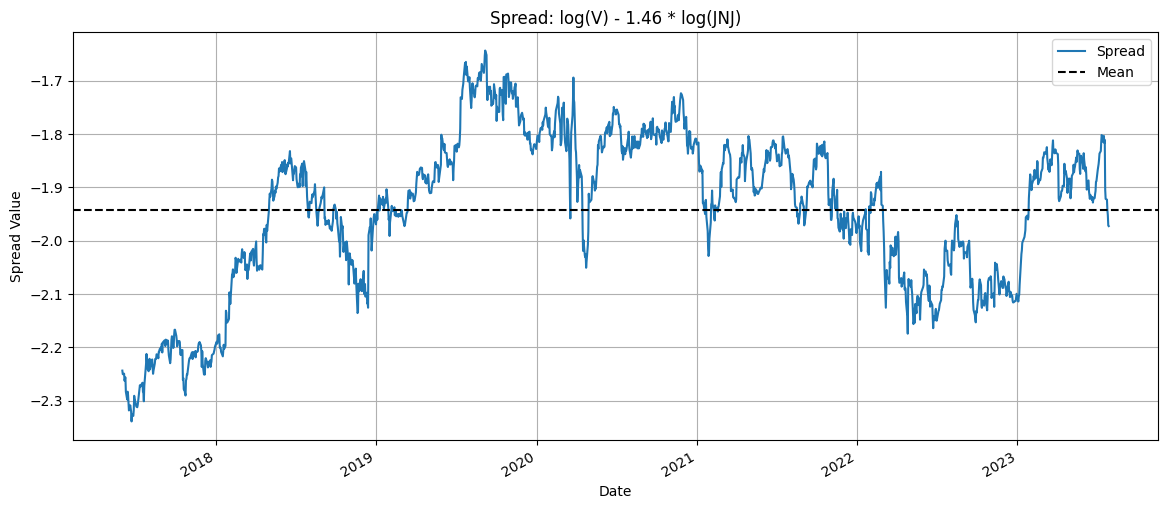

In [19]:
start = '2017-06-01'
end = '2023-07-31'
name_stock1 = asset1
name_stock2 = asset2

stock1_data = yf.Ticker(name_stock1).history(start=start, end=end)
stock2_data = yf.Ticker(name_stock2).history(start=start, end=end)

Y = np.log(stock2_data['Close'])
X = sm.add_constant(np.log(stock1_data['Close']))
model = sm.OLS(Y, X)
results = model.fit()
beta = results.params.iloc[1]
spread = Y - beta * np.log(stock1_data['Close'])

plt.figure(figsize=(14, 6))
spread.plot(label='Spread')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.title(f"Spread: log({name_stock2}) - {beta:.2f} * log({name_stock1})")
plt.xlabel("Date")
plt.ylabel("Spread Value")
plt.legend()
plt.grid(True)
plt.show()

## 7. Z-score Calculation

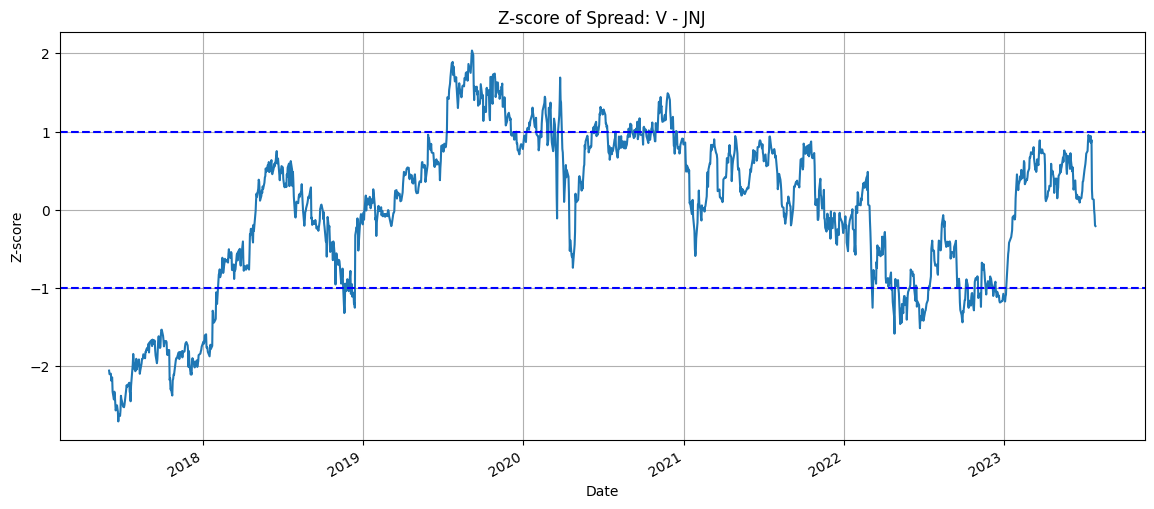

In [20]:
zscore = (spread - spread.mean()) / spread.std()

plt.figure(figsize=(14, 6))
zscore.plot()
plt.axhline(1, color='blue', linestyle='--')
plt.axhline(-1, color='blue', linestyle='--')
plt.title(f"Z-score of Spread: {name_stock2} - {name_stock1}")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.grid(True)
plt.show()

## 8. Generate Buy/Sell Signals

In [21]:
def generate_trade_signals(S1, S2, spread, zscore):
    trades = pd.DataFrame({
        'price1': S1,
        'price2': S2,
        'spread': spread,
        'zscore': zscore
    })
    trades.dropna(inplace=True)
    trades['signal1'] = np.where(trades['zscore'] > 1, -1, np.where(trades['zscore'] < -1, 1, 0))
    trades['signal2'] = -trades['signal1']
    trades['position1'] = trades['signal1'].diff().apply(lambda x: 0 if abs(x) > 1 else x)
    trades['position2'] = trades['signal2'].diff().apply(lambda x: 0 if abs(x) > 1 else x)
    return trades

trade_signals = generate_trade_signals(stock2_data['Close'], stock1_data['Close'], spread, zscore).dropna()

## 9. Visualize Trading Signals

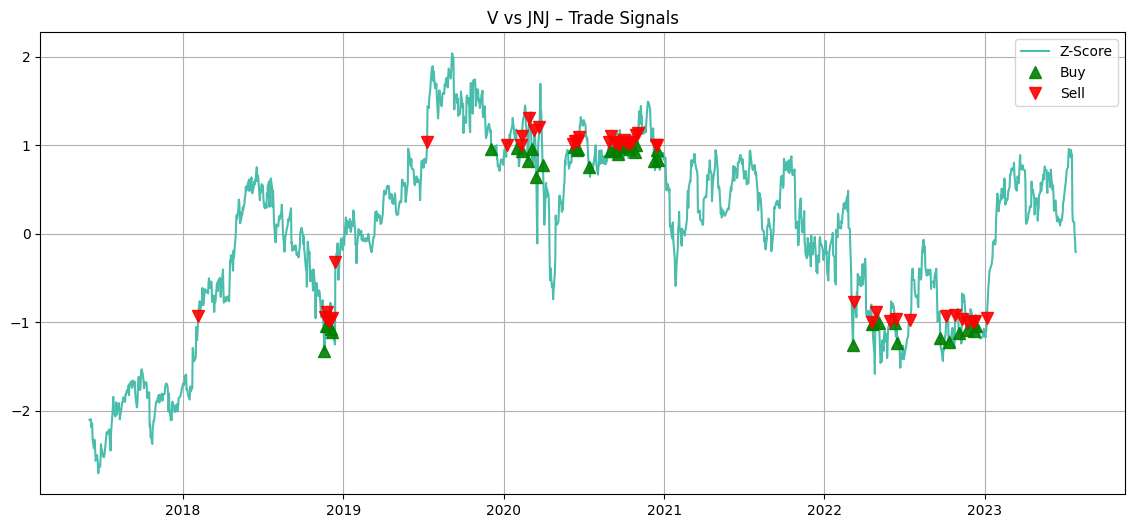

In [22]:
def show_trade_signals(data):
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.plot(data['zscore'], color='#4abdac')
    ax.plot(data['zscore'][data['position1'] == 1], lw=0, marker='^', c='g', markersize=8, alpha=0.9)
    ax.plot(data['zscore'][data['position1'] == -1], lw=0, marker='v', c='r', markersize=8, alpha=0.9)
    plt.title(f'{name_stock2} vs {name_stock1} – Trade Signals')
    plt.legend(['Z-Score', 'Buy', 'Sell'])
    plt.grid(True)
    plt.show()

show_trade_signals(trade_signals)

## 10. Portfolio PnL Calculation

In [23]:
def compute_portfolio(signals):
    capital = 50000
    qty1 = capital // signals['price1'].iloc[0]
    qty2 = capital // signals['price2'].iloc[0]
    pf = pd.DataFrame()
    pf['holdings1'] = signals['position1'].cumsum() * signals['price1'] * qty1
    pf['cash1'] = capital - (signals['position1'] * signals['price1'] * qty1).cumsum()
    pf['total1'] = pf['holdings1'] + pf['cash1']
    pf['return1'] = pf['total1'].pct_change()
    pf['holdings2'] = signals['position2'].cumsum() * signals['price2'] * qty2
    pf['cash2'] = capital - (signals['position2'] * signals['price2'] * qty2).cumsum()
    pf['total2'] = pf['holdings2'] + pf['cash2']
    pf['return2'] = pf['total2'].pct_change()
    pf['total'] = pf['total1'] + pf['total2']
    return pf.dropna()

portfolio = compute_portfolio(trade_signals)

## 11. Portfolio Performance Curve

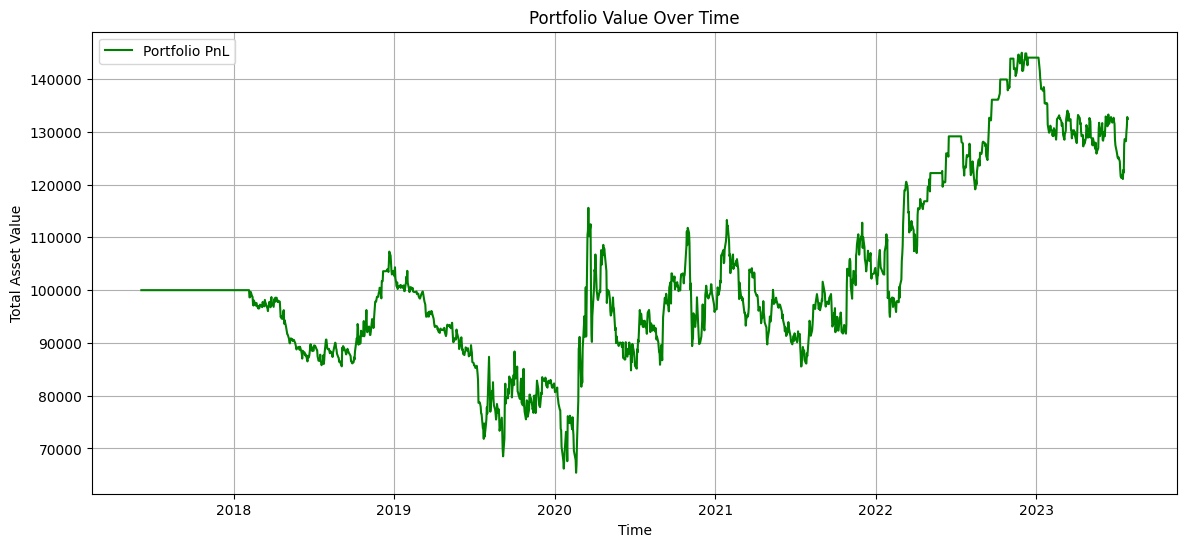

In [24]:
def show_portfolio_curve(pf):
    plt.figure(figsize=(14, 6))
    plt.plot(pf['total'], color='green')
    plt.xlabel('Time')
    plt.ylabel('Total Asset Value')
    plt.title('Portfolio Value Over Time')
    plt.legend(['Portfolio PnL'])
    plt.grid(True)
    plt.show()

show_portfolio_curve(portfolio)